In [ ]:
# default_exp examples.text.glue_low_level_api

In [ ]:
#all_slow

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Using the Low-level fastai API

> This notebook demonstrates how we can use Blurr to tackle the [General Language Understanding Evaluation(GLUE) benchmark](https://gluebenchmark.com/) tasks using the low-level fastai API.  That means we're going to be creating our Datasets (using the dataset creation methods of the datasets library) and DataLoaders (both plain ol' PyTorch DataLoader and fastai DataLoader) to train, evalulate, and do inference.

In [ ]:
#export
from dataclasses import dataclass

import torch
from fastai.text.all import *
from transformers import *
from datasets import load_dataset

from blurr.text.data.core import *
from blurr.text.modeling.core import *
from blurr.text.utils import *
from blurr.utils import *

logging.set_verbosity_error()

In [ ]:
#hide_input
import pdb

from fastcore.test import *
from nbdev.showdoc import show_doc

os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("Here's what we're running with ...\n")
print_versions('torch fastai transformers')

Here's what we're running with ...

torch: 1.10.1+cu111
fastai: 2.5.3
transformers: 4.16.2


In [ ]:
#cuda
#hide_input
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


## GLUE tasks

In [ ]:
#hide_input
glue_tasks = {
    'cola': {
        'abbr': 'CoLA',
        'name': 'Corpus of Linguistic Acceptability',
        'description': 'Predict whether a sequence is a grammatical English sentence',
        'task_type': 'Single-Sentence Task',
        'domain': 'Misc.',
        'size': '8.5k',
        'metrics': 'Matthews corr.',
        'dataset_names': {'train': 'train', 'valid': 'validation', 'test': 'test'},
        'inputs': ['sentence'],
        'target': 'label',
        'metric_funcs': [MatthewsCorrCoef()],
        'n_labels': 2,
    },
    'sst2': {
        'abbr': 'SST-2',
        'name': 'Stanford Sentiment Treebank',
        'description': 'Predict the sentiment of a given sentence',
        'task_type': 'Single-Sentence Task',
        'domain': 'Movie reviews',
        'size': '67k',
        'metrics': 'Accuracy',
        'dataset_names': {'train': 'train', 'valid': 'validation', 'test': 'test'},
        'inputs': ['sentence'],
        'target': 'label',
        'metric_funcs': [accuracy],
        'n_labels': 2
    },
    
    'mrpc': {
        'abbr': 'MRPC',
        'name': 'Microsoft Research Paraphrase Corpus',
        'description': 'Predict whether two sentences are semantically equivalent',
        'task_type': 'Similarity and Paraphrase Tasks',
        'domain': 'News',
        'size': '3.7k',
        'metrics': 'F1/Accuracy',
        'dataset_names': {'train': 'train', 'valid': 'validation', 'test': 'test'},
        'inputs': ['sentence1', 'sentence2'],
        'target': 'label',
        'metric_funcs': [F1Score(), accuracy],
        'n_labels': 2
    },
    'stsb': {
        'abbr': 'SST-B',
        'name': 'Semantic Textual Similarity Benchmark',
        'description': 'Predict the similarity score for two sentences on a scale from 1 to 5',
        'task_type': 'Similarity and Paraphrase Tasks',
        'domain': 'Misc.',
        'size': '7k',
        'metrics': 'Pearson/Spearman corr.',
        'dataset_names': {'train': 'train', 'valid': 'validation', 'test': 'test'},
        'inputs': ['sentence1', 'sentence2'],
        'target': 'label',
        'metric_funcs': [PearsonCorrCoef(), SpearmanCorrCoef()],
        'n_labels': 1
    },
    'qqp': {
        'abbr': 'QQP',
        'name': 'Quora question pair',
        'description': 'Predict if two questions are a paraphrase of one another',
        'task_type': 'Similarity and Paraphrase Tasks',
        'domain': 'Social QA questions',
        'size': '364k',
        'metrics': 'F1/Accuracy',
        'dataset_names': {'train': 'train', 'valid': 'validation', 'test': 'test'},
        'inputs': ['question1', 'question2'],
        'target': 'label',
        'metric_funcs': [F1Score(), accuracy],
        'n_labels': 2
    },
    
    'mnli': {
        'abbr': 'MNLI',
        'name': 'Mulit-Genre Natural Language Inference',
        'description': 'Predict whether the premise entails, contradicts or is neutral to the hypothesis',
        'task_type': 'Inference Tasks',
        'domain': 'Misc.',
        'size': '393k',
        'metrics': 'Accuracy',
        'dataset_names': {'train': 'train', 'valid': 'validation-matched', 'test': 'test'},
        'inputs': ['premise', 'hypothesis'],
        'target': 'label',
        'metric_funcs': [accuracy],
        'n_labels': 3
    },
    'qnli': {
        'abbr': 'QNLI',
        'name': 'Stanford Question Answering Dataset',
        'description': 'Predict whether the context sentence contains the answer to the question',
        'task_type': 'Inference Tasks',
        'domain': 'Wikipedia',
        'size': '105k',
        'metrics': 'Accuracy',
        'dataset_names': {'train': 'train', 'valid': 'validation', 'test': 'test'},
        'inputs': ['question', 'sentence'],
        'target': 'label',
        'metric_funcs': [accuracy],
        'n_labels': 2
    },
    'rte': {
        'abbr': 'RTE',
        'name': 'Recognize Textual Entailment',
        'description': 'Predict whether one sentece entails another',
        'task_type': 'Inference Tasks',
        'domain': 'News, Wikipedia',
        'size': '2.5k',
        'metrics': 'Accuracy',
        'dataset_names': {'train': 'train', 'valid': 'validation', 'test': 'test'},
        'inputs': ['sentence1', 'sentence2'],
        'target': 'label',
        'metric_funcs': [accuracy],
        'n_labels': 2
    },
    'wnli': {
        'abbr': 'WNLI',
        'name': 'Winograd Schema Challenge',
        'description': 'Predict if the sentence with the pronoun substituted is entailed by the original sentence',
        'task_type': 'Inference Tasks',
        'domain': 'Fiction books',
        'size': '634',
        'metrics': 'Accuracy',
        'dataset_names': {'train': 'train', 'valid': 'validation', 'test': 'test'},
        'inputs': ['sentence1', 'sentence2'],
        'target': 'label',
        'metric_funcs': [accuracy],
        'n_labels': 2
    }
}

# for v in glue_tasks.values(): print(v)
glue_tasks.values()

glue_df = pd.DataFrame(glue_tasks.values(), columns=['abbr', 'name', 'task_type', 'description', 'size', 'metrics'])
glue_df.columns = glue_df.columns.str.replace('_', ' ').str.capitalize()
glue_df.style.hide_index()

Abbr,Name,Task type,Description,Size,Metrics
CoLA,Corpus of Linguistic Acceptability,Single-Sentence Task,Predict whether a sequence is a grammatical English sentence,8.5k,Matthews corr.
SST-2,Stanford Sentiment Treebank,Single-Sentence Task,Predict the sentiment of a given sentence,67k,Accuracy
MRPC,Microsoft Research Paraphrase Corpus,Similarity and Paraphrase Tasks,Predict whether two sentences are semantically equivalent,3.7k,F1/Accuracy
SST-B,Semantic Textual Similarity Benchmark,Similarity and Paraphrase Tasks,Predict the similarity score for two sentences on a scale from 1 to 5,7k,Pearson/Spearman corr.
QQP,Quora question pair,Similarity and Paraphrase Tasks,Predict if two questions are a paraphrase of one another,364k,F1/Accuracy
MNLI,Mulit-Genre Natural Language Inference,Inference Tasks,"Predict whether the premise entails, contradicts or is neutral to the hypothesis",393k,Accuracy
QNLI,Stanford Question Answering Dataset,Inference Tasks,Predict whether the context sentence contains the answer to the question,105k,Accuracy
RTE,Recognize Textual Entailment,Inference Tasks,Predict whether one sentece entails another,2.5k,Accuracy
WNLI,Winograd Schema Challenge,Inference Tasks,Predict if the sentence with the pronoun substituted is entailed by the original sentence,634,Accuracy


## Define the task and hyperparmeters

We'll use the "distilroberta-base" checkpoint for this example, but if you want to try an architecture that returns `token_type_ids` for example, you can use something like bert-cased.

In [ ]:
task = 'mrpc'
task_meta = glue_tasks[task]
train_ds_name = task_meta['dataset_names']["train"]
valid_ds_name = task_meta['dataset_names']["valid"]
test_ds_name = task_meta['dataset_names']["test"]

task_inputs =  task_meta['inputs']
task_target =  task_meta['target']
task_metrics = task_meta['metric_funcs']

pretrained_model_name = "distilroberta-base" # bert-base-cased | distilroberta-base

bsz = 16
val_bsz = bsz *2

## Raw data

Let's start by building our `DataBlock`.  We'll load the MRPC datset from huggingface's `datasets` library which will be cached after downloading via the `load_dataset` method.  For more information on the `datasets` API, see the documentation here.

In [ ]:
raw_datasets = load_dataset('glue', task) 
print(f'{raw_datasets}\n')
print(f'{raw_datasets[train_ds_name][0]}\n')
print(f'{raw_datasets[train_ds_name].features}\n')

Reusing dataset glue (/home/wgilliam/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['idx', 'label', 'sentence1', 'sentence2'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['idx', 'label', 'sentence1', 'sentence2'],
        num_rows: 408
    })
    test: Dataset({
        features: ['idx', 'label', 'sentence1', 'sentence2'],
        num_rows: 1725
    })
})

{'idx': 0, 'label': 1, 'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .', 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .'}

{'idx': Value(dtype='int32', id=None), 'label': ClassLabel(num_classes=2, names=['not_equivalent', 'equivalent'], names_file=None, id=None), 'sentence1': Value(dtype='string', id=None), 'sentence2': Value(dtype='string', id=None)}



## Prepare the Hugging Face objects

My #1 answer as to the question, "Why aren't my transformers training?", is that you likely don't have `num_labels` set correctly.  The default for sequence classification tasks is 2, and even though that is what we have here, let's show how to set this either way.

In [ ]:
n_lbls = raw_datasets[train_ds_name].features[task_target].num_classes
n_lbls

2

In [ ]:
model_cls = AutoModelForSequenceClassification

hf_arch, hf_config, hf_tokenizer, hf_model = NLP.get_hf_objects(pretrained_model_name, 
                                                                  model_cls=model_cls, 
                                                                  config_kwargs={'num_labels': n_lbls})

print(hf_arch)
print(type(hf_config))
print(type(hf_tokenizer))
print(type(hf_model))

roberta
<class 'transformers.models.roberta.configuration_roberta.RobertaConfig'>
<class 'transformers.models.roberta.tokenization_roberta_fast.RobertaTokenizerFast'>
<class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'>


## Build the tokenized datasets

Tokenize (and numericalize) the raw text using the `datasets.map` function, and then remove unnecessary and/or problematic attributes from the resulting tokenized dataset (e.g., things like strings that can't be converted to a tensor)

In [ ]:
def tokenize_function(example):
    return hf_tokenizer(*[example[inp] for inp in task_inputs ], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
tokenized_datasets = tokenized_datasets.remove_columns(task_inputs + ['idx'])
tokenized_datasets = tokenized_datasets.rename_column('label', 'labels')
tokenized_datasets["train"].column_names

['attention_mask', 'input_ids', 'labels']

## 1. Using PyTorch DataLoaders

### Build the DataLoaders

`BlurrBatchCreator` augments the default `DataCollatorWithPadding` method to return a tuple of inputs/targets. As huggingface returns a `BatchEncoding` object after the call to `DataCollatorWithPadding`, this class will convert it to a `dict` so that fastai can put the batches on the correct device for training

Build the plain ol' PyTorch `DataLoaders`

In [ ]:
data_collator = TextBatchCreator(hf_arch, hf_config, hf_tokenizer, hf_model)

train_dataloader = torch.utils.data.DataLoader(tokenized_datasets[train_ds_name], shuffle=True, batch_size=bsz, 
                                               collate_fn=data_collator)

eval_dataloader = torch.utils.data.DataLoader(tokenized_datasets[valid_ds_name], batch_size=val_bsz, 
                                              collate_fn=data_collator)

In [ ]:
dls = DataLoaders(train_dataloader, eval_dataloader)

In [ ]:
for b in dls.train: break
b[0]['input_ids'].shape, b[1].shape, b[0]['input_ids'].device, b[1].device

(torch.Size([16, 72]),
 torch.Size([16]),
 device(type='cpu'),
 device(type='cpu'))

### Train

With our plain ol' PyTorch DataLoaders built, we can now build our `Learner` and train. 

**Note**: Certain fastai methods like `dls.one_batch`, `get_preds` and `dls.test_dl` won't work with standard PyTorch DataLoaders ... but we'll show how to remedy that in a moment :)

In [ ]:
model = BaseModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=partial(Adam),
                loss_func=PreCalculatedCrossEntropyLoss(),
                metrics=task_metrics,
                cbs=[BaseModelCallback],
                splitter=blurr_splitter).to_fp16()

learn.freeze()

In [ ]:
#hide_output
learn.summary()

SuggestedLRs(minimum=0.00036307806149125097, steep=0.015848932787775993, valley=0.0006918309954926372, slide=0.001737800776027143)

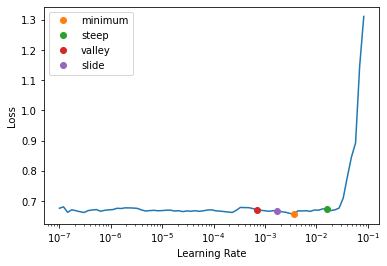

In [ ]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(1, lr_max=2e-3)

epoch,train_loss,valid_loss,f1_score,accuracy,time
0,0.532319,0.480080,0.843450,0.759804,00:10


SuggestedLRs(minimum=1.3779609397968073e-11, steep=8.513399187004556e-12, valley=4.234914013068192e-05, slide=2.2274794901022688e-05)

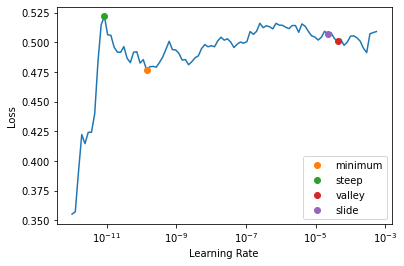

In [ ]:
learn.unfreeze()
learn.lr_find(start_lr=1e-12, end_lr=2e-3, suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(2, lr_max=slice(2e-5, 2e-4))

epoch,train_loss,valid_loss,f1_score,accuracy,time
0,0.467265,0.358624,0.889643,0.840686,00:19
1,0.279453,0.335163,0.910321,0.870098,00:19


### Evaluate

How did we do?

In [ ]:
val_res = learn.validate()

In [ ]:
val_res_d = { 'loss': val_res[0]}
for idx, m in enumerate(learn.metrics): val_res_d[m.name] = val_res[idx+1]
    
val_res_d

{'loss': 0.33516255021095276,
 'f1_score': 0.9103214890016922,
 'accuracy': 0.8700980544090271}

In [ ]:
#hide_output
# preds, targs = learn.get_preds()  # ... won't work :(

### Inference

Let's do **item inference** on an example from our test dataset

In [ ]:
raw_test_df = raw_datasets[test_ds_name].to_pandas()
raw_test_df.head()

,idx,label,sentence1,sentence2
0,0,1,"PCCW 's chief operating officer , Mike Butcher , and Alex Arena , the chief financial officer , will report directly to Mr So .",Current Chief Operating Officer Mike Butcher and Group Chief Financial Officer Alex Arena will report to So .
1,1,1,The world 's two largest automakers said their U.S. sales declined more than predicted last month as a late summer sales frenzy caused more of an industry backlash than expected .,Domestic sales at both GM and No. 2 Ford Motor Co. declined more than predicted as a late summer sales frenzy prompted a larger-than-expected industry backlash .
2,2,1,"According to the federal Centers for Disease Control and Prevention ( news - web sites ) , there were 19 reported cases of measles in the United States in 2002 .",The Centers for Disease Control and Prevention said there were 19 reported cases of measles in the United States in 2002 .
3,3,0,A tropical storm rapidly developed in the Gulf of Mexico Sunday and was expected to hit somewhere along the Texas or Louisiana coasts by Monday night .,A tropical storm rapidly developed in the Gulf of Mexico on Sunday and could have hurricane-force winds when it hits land somewhere along the Louisiana coast Monday night .
4,4,0,The company didn 't detail the costs of the replacement and repairs .,But company officials expect the costs of the replacement work to run into the millions of dollars .


In [ ]:
test_ex_idx = 0
test_ex = raw_test_df.iloc[test_ex_idx][task_inputs].values.tolist()

In [ ]:
inputs = hf_tokenizer(*test_ex, return_tensors="pt").to('cuda:1')

In [ ]:
outputs = hf_model(**inputs)
outputs.logits

tensor([[-1.6640,  1.0325]], device='cuda:1', grad_fn=<AddmmBackward0>)

In [ ]:
torch.argmax(torch.softmax(outputs.logits, dim=-1))

tensor(1, device='cuda:1')

Let's do **batch inference** on the entire test dataset

In [ ]:
# test_dl = dls.test_dl(tokenized_datasets[test_ds_name]) # ... won't work :(

test_dataloader = torch.utils.data.DataLoader(tokenized_datasets[test_ds_name], 
                                              shuffle=False, batch_size=val_bsz, 
                                              collate_fn=data_collator)

hf_model.eval()

probs, preds = [], []
for xb,yb in test_dataloader: 
    xb = to_device(xb,'cuda')
    with torch.no_grad(): 
        outputs = hf_model(**xb)
        
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    
    probs.append(logits)
    preds.append(predictions)

In [ ]:
all_probs = torch.cat(probs, dim=0)
all_preds = torch.cat(preds, dim=0)

print(all_probs.shape, all_preds.shape)

torch.Size([1725, 2]) torch.Size([1725])


## 2. Using fastai DataLoaders

Let's start with a fresh set of huggingface objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = NLP.get_hf_objects(pretrained_model_name, 
                                                                  model_cls=model_cls, 
                                                                  config_kwargs={'num_labels': n_lbls})

... ***and the fix is this simple!***  Instead of using the PyTorch Dataloaders, let's use the fastai flavor like this ...

In [ ]:
train_dataloader = TextDataLoader(tokenized_datasets[train_ds_name], 
                                   hf_arch, hf_config, hf_tokenizer, hf_model,
                                   preproccesing_func=preproc_hf_dataset, shuffle=True, batch_size=bsz)

eval_dataloader = TextDataLoader(tokenized_datasets[valid_ds_name],
                                  hf_arch, hf_config, hf_tokenizer, hf_model,
                                  preproccesing_func=preproc_hf_dataset, batch_size=val_bsz)

dls = DataLoaders(train_dataloader, eval_dataloader)

Everything else is the same ... ***but*** now we get both our fast.ai AND Blurr features back!

In [ ]:
dls.show_batch(dataloaders=dls, trunc_at=500, max_n=2)

,text,target
0,"The broader Standard & Poor's 500 Index <.SPX > edged down 9 points, or 0.98 percent, to 921. The Standard & Poor's 500 Index shed 5.20, or 0.6 percent, to 924.42 as of 9 : 33 a.m. in New York.",1
1,""" When I talked to him last time, did I think that was the end-all - one conversation with somebody? When I talked to him last time, did I think it was the end-all?",1


In [ ]:
b = dls.one_batch()
b[0]['input_ids'].shape, b[1].shape, b[0]['input_ids'].device, b[1].device

(torch.Size([16, 81]),
 torch.Size([16]),
 device(type='cpu'),
 device(type='cpu'))

### Train

In [ ]:
model = BaseModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=partial(Adam),
                loss_func=PreCalculatedCrossEntropyLoss(),
                metrics=task_metrics,
                cbs=[BaseModelCallback],
                splitter=blurr_splitter).to_fp16()

learn.freeze()

SuggestedLRs(minimum=0.0007585775572806596, steep=0.0063095735386013985, valley=0.0004786300996784121, slide=0.0003981071640737355)

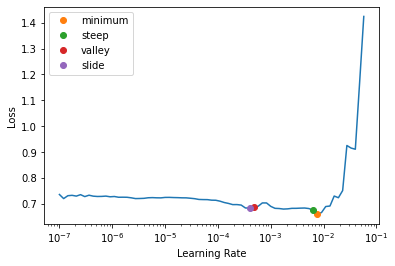

In [ ]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(1, lr_max=2e-3)

epoch,train_loss,valid_loss,f1_score,accuracy,time
0,0.531747,0.474415,0.855738,0.784314,00:12


SuggestedLRs(minimum=1.6185790555067748e-12, steep=1.3065426344993636e-11, valley=7.238505190798605e-07, slide=1.451419939257903e-05)

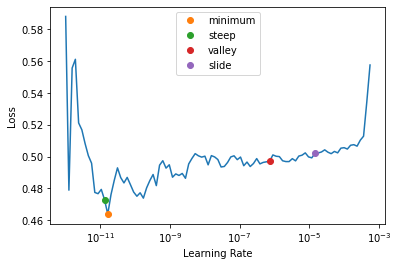

In [ ]:
learn.unfreeze()
learn.lr_find(start_lr=1e-12, end_lr=2e-3, suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(2, lr_max=slice(2e-5, 2e-4))

epoch,train_loss,valid_loss,f1_score,accuracy,time
0,0.461239,0.342700,0.887299,0.845588,00:20
1,0.274237,0.305770,0.897527,0.857843,00:20


In [ ]:
learn.show_results(learner=learn, trunc_at=500, max_n=2)

,text,target,prediction
0,The state's House delegation currently consists of 17 Democrats and 15 Republicans. Democrats hold a 17-15 edge in the state's U.S. House delegation.,1,0
1,"The announcement was made during the recording of a Christmas concert attended by top Vatican cardinals, bishops, and many elite from Italian society, witnesses said. The broadside came during the recording on Saturday night of a Christmas concert attended by top Vatican cardinals, bishops and many elite of Italian society, witnesses said.",1,1


### Evaluate

How did we do?

In [ ]:
val_res = learn.validate()

In [ ]:
val_res_d = { 'loss': val_res[0]}
for idx, m in enumerate(learn.metrics): val_res_d[m.name] = val_res[idx+1]
    
val_res_d

{'loss': 0.30576950311660767,
 'f1_score': 0.8975265017667844,
 'accuracy': 0.8578431606292725}

Now we can use `Learner.get_preds()`

In [ ]:
preds, targs = learn.get_preds()
print(preds.shape, targs.shape)
print(accuracy(preds, targs))

torch.Size([408, 2]) torch.Size([408])
TensorBase(0.8578)


### Inference

Let's do **item inference** on an example from our test dataset

In [ ]:
raw_test_df = raw_datasets[test_ds_name].to_pandas()
raw_test_df.head()

,idx,label,sentence1,sentence2
0,0,1,"PCCW 's chief operating officer , Mike Butcher , and Alex Arena , the chief financial officer , will report directly to Mr So .",Current Chief Operating Officer Mike Butcher and Group Chief Financial Officer Alex Arena will report to So .
1,1,1,The world 's two largest automakers said their U.S. sales declined more than predicted last month as a late summer sales frenzy caused more of an industry backlash than expected .,Domestic sales at both GM and No. 2 Ford Motor Co. declined more than predicted as a late summer sales frenzy prompted a larger-than-expected industry backlash .
2,2,1,"According to the federal Centers for Disease Control and Prevention ( news - web sites ) , there were 19 reported cases of measles in the United States in 2002 .",The Centers for Disease Control and Prevention said there were 19 reported cases of measles in the United States in 2002 .
3,3,0,A tropical storm rapidly developed in the Gulf of Mexico Sunday and was expected to hit somewhere along the Texas or Louisiana coasts by Monday night .,A tropical storm rapidly developed in the Gulf of Mexico on Sunday and could have hurricane-force winds when it hits land somewhere along the Louisiana coast Monday night .
4,4,0,The company didn 't detail the costs of the replacement and repairs .,But company officials expect the costs of the replacement work to run into the millions of dollars .


In [ ]:
test_ex_idx = 0
test_ex = raw_test_df.iloc[test_ex_idx][task_inputs].values.tolist()

In [ ]:
inputs = hf_tokenizer(*test_ex, return_tensors="pt").to('cuda:1')

In [ ]:
outputs = hf_model(**inputs)
outputs.logits

tensor([[-1.8848,  2.3550]], device='cuda:1', grad_fn=<AddmmBackward0>)

In [ ]:
torch.argmax(torch.softmax(outputs.logits, dim=-1))

tensor(1, device='cuda:1')

Let's do **batch inference** on the entire test dataset using `dls.test_dl`

In [ ]:
test_dl = dls.test_dl(tokenized_datasets[test_ds_name])
preds = learn.get_preds(dl=test_dl)
preds

(tensor([[0.0142, 0.9858],
         [0.0965, 0.9035],
         [0.0098, 0.9902],
         ...,
         [0.0504, 0.9496],
         [0.0096, 0.9904],
         [0.0355, 0.9645]]),
 tensor([1, 1, 1,  ..., 0, 1, 1]))

## Summary

So you can see, with one simple swap of the `DataLoader` objects, you can get back a lot of that nice fastai functionality folks using the mid/high-level APIs have at their disposal. Nevertheless, if you're hell bent on using the standard PyTorch `DataLoaders`, you're still good to go with using the fastai `Learner`, it's callbacks, etc...

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_callbacks.ipynb.
Converted 00_utils.ipynb.
Converted 01_text-callbacks.ipynb.
Converted 01_text-utils.ipynb.
Converted 11_text-data-core.ipynb.
Converted 11_text-modeling-core.ipynb.
Converted 12_text-data-language-modeling.ipynb.
Converted 12_text-modeling-language-modeling.ipynb.
Converted 13_text-data-token-classification.ipynb.
Converted 13_text-modeling-token-classification.ipynb.
Converted 14_text-data-question-answering.ipynb.
Converted 14_text-modeling-question-answering.ipynb.
Converted 20_text-data-seq2seq-core.ipynb.
Converted 20_text-modeling-seq2seq-core.ipynb.
Converted 21_text-data-seq2seq-summarization.ipynb.
Converted 21_text-modeling-seq2seq-summarization.ipynb.
Converted 22_text-data-seq2seq-translation.ipynb.
Converted 22_text-modeling-seq2seq-translation.ipynb.
Converted 99a_text-examples-high-level-api.ipynb.
Converted 99b_text-examples-glue.ipynb.
Converted 99c_text-examples-glue-plain-pytorch.ipynb.
Converted 99d_text-examples-multilabel.ipynb.
Conv